<H3> Astrometry quality checks </H3>

The idea is to compute the distribution of the angular distances between matched sources from a set of exposures covering the same area. We arbitrarily take the first exposure as a reference.

The angular distance is computed:
<OL>
<LI> using the source coordinates associated to the "src" catalog, thus corresponding to the standard astrometric solution (fit using an external reference catalog only)</LI>
<LI> using the updated WCS from the simultaneous astrometry fit</LI>
</OL>

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import numpy as np
import math

from astropy.table import Table

# List of visits to be considered
#visits = [793169, 838864, 849375, 895369, 918238, 996230]
visits = [895367, 895368, 895369, 895370, 895371]

# Reference visit
ref = 895367

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = range(36)

filter = 'r'

fluxType = "base_CircularApertureFlux_17_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssShape_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output/coadd_dir")
    
calibRef = [None]*36
oldWcsRef = [None]*36
newWcsRef = [None]*36

T = Table(names=("id", "dist", "disto", "visit", "ccdRef", "ccdVis", "mag", "ra", "dec"), 
          dtype=('i','f', 'f', 'i', 'i2', 'i2', 'f', 'S12', 'S12'))

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=np.int32, doc="CCD number")

        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
        srcRef.reserve(1000000)

    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)
        
    # retrieve the calibration object associated to the CCDs
    mdRef = butler.get("calexp_md", dataid, immediate=True)
    calibRef[c] =afwImage.Calib(mdRef)
        
    # retrieve the original and improved wcs
    oldWcsRef[c] = afwImage.makeWcs(mdRef)
    dataidNew = {'visit':ref, 'filter':filter, 'ccd':c, 'tract':tract}
    newWcsRefCont = butler.get('wcs', dataidNew, immediate=True)
    newWcsRef[c] = newWcsRefCont.getWcs()

print "Ref...", len(srcRef)
    
# Store original and updated Wcs associated to each visit / ccd
oldWcsVis = {}
newWcsVis = {}
for v in visits :
    oldWcsVis[v] = [None]*36
    newWcsVis[v] = [None]*36
    for c in ccd :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        dataidNew = {'visit':v, 'filter':filter, 'ccd':c, 'tract':tract}
        mdVis = butler.get("calexp_md", dataid, immediate=True)
        oldWcsVis[v][c] = afwImage.makeWcs(mdVis)
        newWcsVisCont = butler.get('wcs', dataidNew, immediate=True)
        newWcsVis[v][c] = newWcsVisCont.getWcs()

mag = []
oldDist = []
newDist = []
xSig = []
ff = 0
for indV, v in enumerate(visits) :
    if v == ref :
        continue
    if ff == 0 :
        ff = 1
    for indC, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        src = butler.get('src', dataid, immediate=True)

        match = afwTable.matchRaDec(srcRef, src, afwGeom.Angle(1./3600., afwGeom.degrees))

        schemaRef = srcRef.getSchema()
        if ff == 1 and indC == 0 :
            ff = 2
            schemaSrc = src.getSchema()
            flagKeyRef = []
            flagKeyVis = []
            for f in Flags :
                keyRef = schemaRef[f].asKey()
                flagKeyRef.append(keyRef)
                keyVis = schemaSrc[f].asKey()
                flagKeyVis.append(keyVis)

            extendKey = newSchema["base_ClassificationExtendedness_value"].asKey()
            fluxKey = newSchema[fluxType + "_flux"].asKey()
            fluxSigmaKey = newSchema[fluxType + "_fluxSigma"].asKey()
            ccdKeyRef = newSchema["ccd"].asKey()
            
            xSigmaKey = schemaSrc["base_SdssCentroid_xSigma"].asKey()
            ySigmaKey = schemaSrc["base_SdssCentroid_ySigma"].asKey()
            mxxKey = schemaSrc["base_SdssShape_xx"].asKey()
            myyKey = schemaSrc["base_SdssShape_yy"].asKey()
            mxyKey = schemaSrc["base_SdssShape_xy"].asKey()              

        for m in match :
            mRef = m.first
            mVis = m.second

            for f in flagKeyRef :
                rej = 0
                if mRef.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
            for f in flagKeyVis :
                rej = 0
                if mVis.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                    continue
                    
            # cleanup the reference sources in order to keep only decent star-like objects
            if mRef.get(extendKey) >= 0.5 :
                continue

            ang = afwGeom.radToMas(m.distance)

            # retrieve the CCD corresponding to the reference source
            ccdRef = mRef.get(ccdKeyRef)
            ccdVis = c

            # compute magnitude
            calib = calibRef[ccdRef]
            flux = mRef.get(fluxKey)
            fluxSigma = mRef.get(fluxSigmaKey)
            if flux /fluxSigma < 5 :
                continue
            if flux > 0. :
                refMag = calib.getMagnitude(flux)
            else :
                continue
            if refMag < 16.5 or refMag > 26 :
                continue

            footprint = mVis.getFootprint()
            if footprint is not None and len(footprint.getPeaks()) > 1 :
                continue
                
            # Check consistency of the source covariance parameters
            vx = np.square(mVis.get(xSigmaKey))
            vy = np.square(mVis.get(ySigmaKey))
            mxx = mVis.get(mxxKey)
            myy = mVis.get(myyKey)
            mxy = mVis.get(mxyKey)
            vxy = mxy*(vx+vy)/(mxx+myy)
            if (vxy*vxy)>(vx*vy) or np.isnan(vx) or np.isnan(vy):
                print "Error in covariance : ", v, c, ccdRef, vxy*vxy, vx*vy, vx, vy, mVis.get("base_SdssCentroid_flag"), mVis.get("base_SdssShape_flag")
                print mVis.get(xSigmaKey), mVis.get(ySigmaKey), mxx, myy, mxy
                print mVis.get("base_SdssCentroid_x"), mVis.get("base_SdssCentroid_y")
                continue

            oldCoordRef = mRef.getCoord()
            pixelsRef = oldWcsRef[ccdRef].skyToPixel(oldCoordRef.getRa(), oldCoordRef.getDec())
            newCoordRef = newWcsRef[ccdRef].pixelToSky(pixelsRef).toIcrs()

            oldCoordVis = mVis.getCoord()
            pixelsVis = oldWcsVis[v][c].skyToPixel(oldCoordVis.getRa(), oldCoordVis.getDec())
            newCoordVis = newWcsVis[v][c].pixelToSky(pixelsVis).toIcrs()

            newAngle = 1000.0*newCoordRef.angularSeparation(newCoordVis).asArcseconds()       

            mag.append(refMag)
            oldDist.append(ang)
            newDist.append(newAngle)
            xSig.append(mVis.get(xSigmaKey))
            
            if refMag<20 and newAngle>50 :
                ra = afwGeom.Angle.asDegrees(m.first.getCoord().getRa())
                dec = afwGeom.Angle.asDegrees(m.first.getCoord().getDec())
                T.add_row((m.first.get("id"), newAngle, ang, v, ccdRef, ccdVis, refMag, ra, dec))

T_id = T.group_by("id")                
T_id.pprint(max_lines=-1, max_width=-1)

0 1629
1 1845
2 2060
3 1894
4 1804
5 2163
6 1786
7 1907
8 1750
9 2001
10 1826
11 1811
12 1604
13 1626
14 1682
15 2164
16 1818
17 1584
18 1782
19 1645
20 1654
21 1656
22 1852
23 1456
24 1751
25 1657
26 1581
27 1877
28 1774
29 1580
30 1842
31 1822
32 1741
33 1889
34 1822
35 1837
Ref... 64172
Error in covariance :  895368 2 2 1.01023204741 0.812040782086 0.948503540128 0.856128361921 False True
0.973911464214 0.92527204752 13280.0616182 4213.59512852 9743.22071791
1145.46262533 1073.52800667
Error in covariance :  895368 6 7 nan nan nan nan True False
nan nan 4.60799743593 4.45227850685 0.217551199597
21.0 192.0
Error in covariance :  895368 7 7 nan nan nan nan True False
nan nan 4.24700234098 3.70362332121 0.285681115327
2028.0 2498.0
Error in covariance :  895368 10 10 nan nan nan nan True True
nan nan 297.757674648 735.543753033 123.784162355
1632.0 713.0
Error in covariance :  895368 14 23 nan nan nan nan True False
nan nan 8.76447575564 5.09533797673 0.293576235771
2018.0 4553.0
Erro

### Plot results for the standard astrometric solution (fit source coordinates to an external reference catalog only)

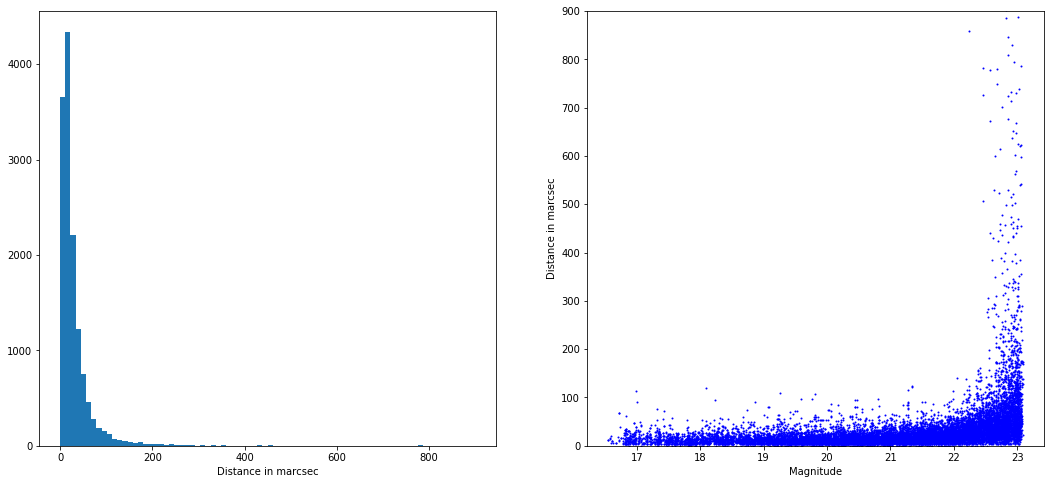

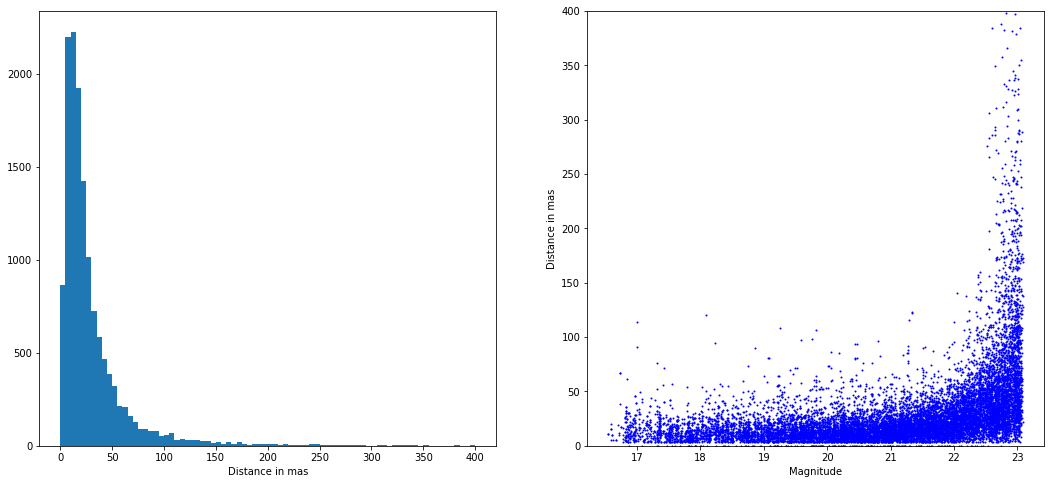

Median value of the astrometric scatter : 19.1945329629 mas


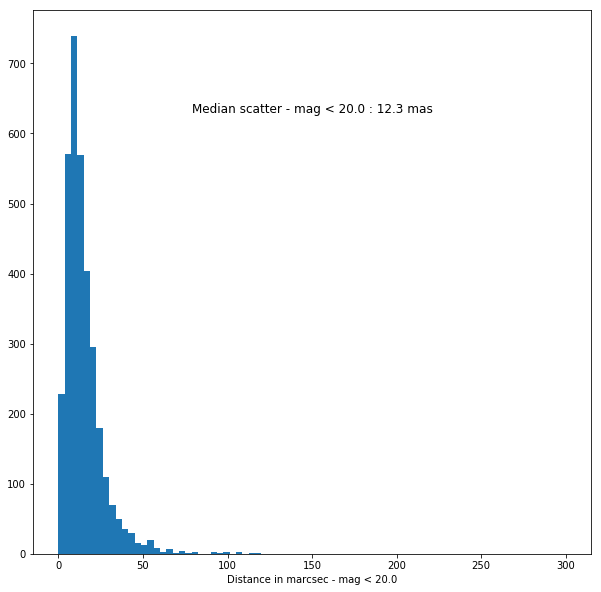

Median scatter - mag < 20.0 : 12.3 mas


In [2]:

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist, bins=80, range=[0.,900.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(oldDist,bins=80, range=[0.,400.])
ax1.scatter(mag, oldDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(oldDist), "mas"

magLim = 20
idxs = np.where(np.asarray(mag) < magLim)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(oldDist)[idxs], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),x=0.5, y=0.8)
plt.show()

print "Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs]))

### Plot results for astrometric solution from the simultaneous fit

Median value of the astrometric scatter : 11.3779630936 mas
Astrometric scatter (median) - mag < 20.0 : 4.5 mas


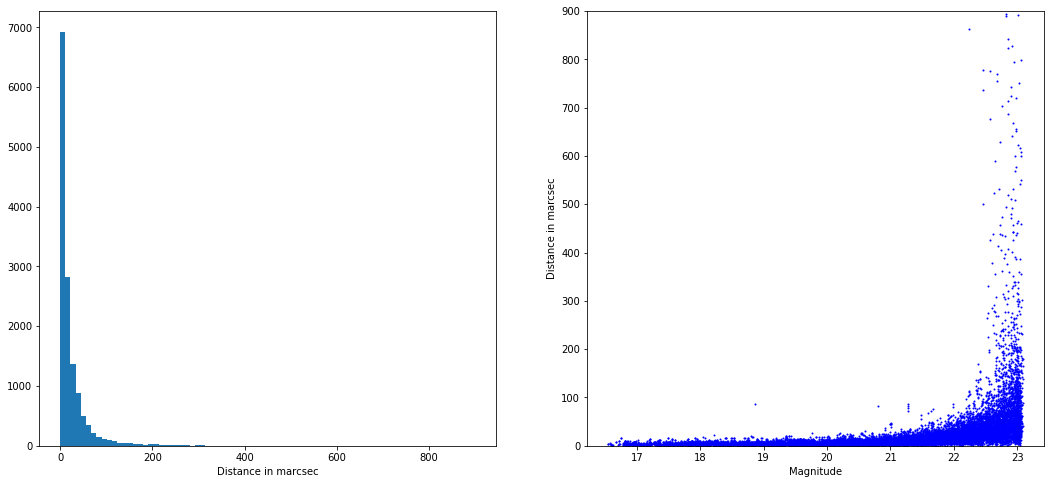

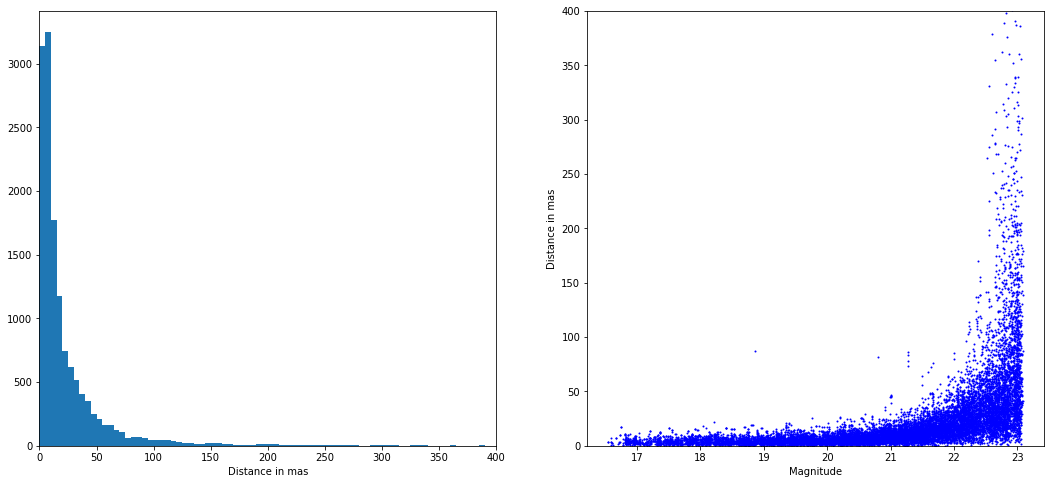

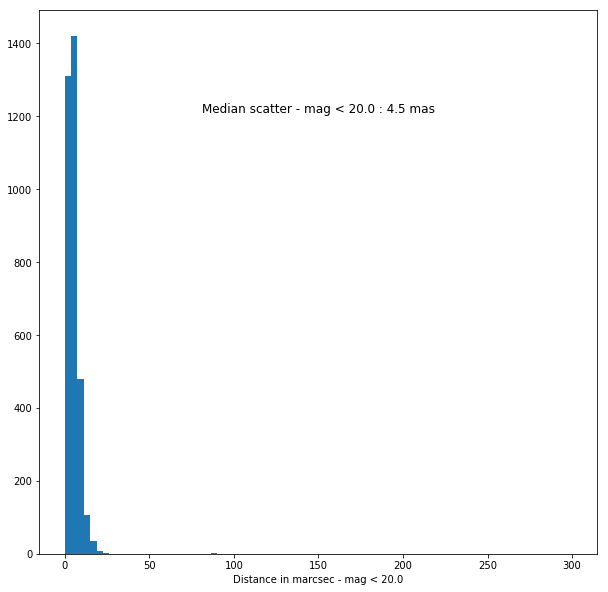

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist, bins=80, range=[0., 900.])
ax1.scatter(mag, newDist, s=1, color='b')
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(newDist,bins=80, range=[0., 400.])
ax0.set_xlim([0.,400.])
ax1.scatter(mag, newDist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")

print "Median value of the astrometric scatter :", np.median(newDist), "mas"

magLim = 20
idxs2 = np.where(np.asarray(mag) < magLim)
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 300.])
ax0.set_xlabel("Distance in marcsec - mag < %0.1f"%(magLim))
ax0.set_title("Median scatter - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs])),x=0.5, y=0.8)

print "Astrometric scatter (median) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs]))

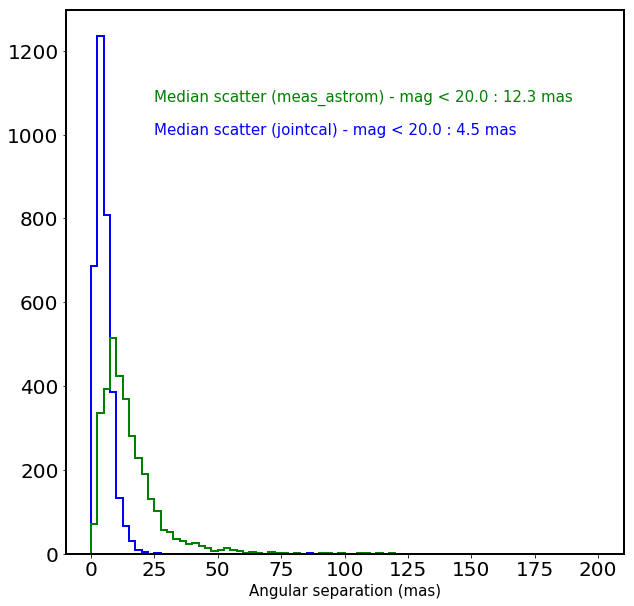

In [5]:
font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 2 
plt.rcParams['mathtext.default'] = 'regular'

fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(newDist)[idxs2], bins=80, range=[0., 200.], color='b', histtype = 'step', lw=2)
ax0.set_xlabel("Angular separation (mas)", fontsize=15)

ax0.hist(np.asarray(oldDist)[idxs], bins=80, range=[0., 200.], color='g', histtype = 'step', lw=2)
ax0.tick_params(labelsize=20)

ax0.text(25, 1000, "Median scatter (jointcal) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(newDist)[idxs2])),
             fontsize=15, color='b')
ax0.text(25, 1080, "Median scatter (meas_astrom) - mag < %0.1f : %0.1f mas"%(magLim, np.median(np.asarray(oldDist)[idxs])),
             fontsize=15, color='g')

In [12]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

dataid = {'visit':996230, 'filter':'r', 'ccd':10}
dataid2 = {'visit':996230, 'filter':'r', 'ccd':10, 'tract':0 }

butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output/coadd_dir")

exp = butler.get('calexp', dataid2, immediate=True)
wcsCont = butler.get('wcs', dataid2, immediate=True)
newWcs = afwImage.TanWcs.cast(wcsCont.getWcs())
src = butler.get('src', dataid, immediate=True)

md = butler.get("calexp_md",dataid, immediate=True)
oldWcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))

oldCoord = src[10].getCoord()
print oldCoord.getRa(), oldCoord.getDec()
oldRa = src[10].getRa()
oldDec = src[10].getDec()
print "old Coord", oldCoord

pixels = oldWcs.skyToPixel(oldCoord)
cc = oldWcs.pixelToSky(pixels).toIcrs()
print "Coord with reverse transformation - old WCS", cc
print "pixels with old wcs", pixels
newCoord = newWcs.pixelToSky(pixels).toIcrs()
newPixels = newWcs.skyToPixel(newCoord)
print "pixels with new wcs", newPixels
print newCoord
print

point = afwGeom.Point2D(100., 200.)
newCoord = newWcs.pixelToSky(point)
pointCheck = newWcs.skyToPixel(newCoord)

print "Verif new wcs - Point", point, "should be equal to ", pointCheck

point = afwGeom.Point2D(100., 200.)
oldCoord = oldWcs.pixelToSky(point)
pointCheck = oldWcs.skyToPixel(oldCoord)

print "Verif old wcs - Point", point, "should be equal to ", pointCheck

3.76001 rad 0.923578 rad
old Coord IcrsCoord(215.4327495, 52.9171290)
Coord with reverse transformation - old WCS IcrsCoord(215.4327496, 52.9171289)
pixels with old wcs (1288.8, 45.932)
pixels with new wcs (1288.8, 45.932)
IcrsCoord(215.4327615, 52.9171666)

Verif new wcs - Point (100, 200) should be equal to  (100, 200)
Verif old wcs - Point (100, 200) should be equal to  (100, 200)


In [30]:
a = [match[i].first.get("id") for i in range(10)]
print a

[122639007271092226, 122639007271092225, 122639007271092229, 122639007271092232, 122639007271092230, 122639007271092231, 122639007271092233, 122639007271092234, 122639007271094277, 122639007271092235]


In [48]:
from astropy.table import Table

row = (1, 0.01, 99756, 12)
T = Table(names=("id", "dist", "visit", "ccd"), dtype=('i','f', 'i', 'i2'))
T.add_row(row)

In [49]:
print T

 id dist visit ccd
--- ---- ----- ---
  1 0.01 99756  12


In [68]:
print dir(m.first.getCoord())
print m.first.getCoord().getRaStr(afwGeom.degrees)

['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__eq__', '__format__', '__getattr__', '__getattribute__', '__getitem__', '__hash__', '__init__', '__iter__', '__len__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_eq_impl', '_ne_impl', '_s', 'angularSeparation', 'cast', 'clone', 'convert', 'getClassName', 'getCoordNames', 'getCoordSystem', 'getDec', 'getDecStr', 'getEpoch', 'getLatitude', 'getLatitudeStr', 'getLongitude', 'getLongitudeStr', 'getOffsetFrom', 'getPosition', 'getRa', 'getRaStr', 'getTangentPlaneOffset', 'getVector', 'offset', 'reset', 'rotate', 'this', 'toEcliptic', 'toFk5', 'toGalactic', 'toIcrs', 'toTopocentric', 'transform']
214:38:18.46


In [86]:
T_id.pprint(max_lines=-1, max_width=-1)

 id    dist  visit  ccdRef ccdVis   mag        ra          dec     
---- ------- ------ ------ ------ ------- ------------ ------------
  12 56.0724 849375     15      6 19.4281 214.45880604 52.943628666
  12 54.8817 895369     15      6 19.4281 214.45880604 52.943628666
  19 76.6486 996230     20     20 16.9974 215.16896805 52.469354778
  21 52.9027 996230     18     18 19.2935 215.64961410 52.469861397
  46 50.0215 895369     19     19 18.6904 215.41656840 52.472093620
  46 99.4576 996230     19     19 18.6904 215.41656840 52.472093620
  70 64.3053 996230     34     34 19.4156 214.25351982 52.214964677
 116 50.7055 918238     28     28 19.2717 215.36959154 52.221639429
 116 64.1539 996230     28     28 19.2717 215.36959154 52.221639429
 116 50.4403 996230     33     33 18.8921 214.47586343 52.221809901
 164 55.3564 849375     14      5 18.6382 214.62633761 52.926863183
 164 98.6145 895369     14      5 18.6382 214.62633761 52.926863183
 164 57.8863 918238     14     14 18.6382 214.62